# FINAL PROJECT SHAPES

In [21]:
# imports
from PIL import Image
import os
import glob
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import cv2
import numpy as np
import imutils

# Preparing the images for the assimilation phase to the algorithm

### At this stage we process all the images according to the correct sizes and crop them in order to implement the SSIM algorithm

In [2]:
#Function that making the image only with the colors black and white
#input: image(matrix)
#output: white_black image(matrix)
def makingImageBlackAndWhite(image_obj, threshold_value = 127):
    (thresh, BnW_image_obj) = cv2.threshold(image_obj, threshold_value, 255, cv2.THRESH_BINARY)
    return BnW_image_obj

In [3]:
#This function was created to find the best values for the crop, for avery image we will find the min_max values to cut it.
#input(image(matrix),int flag)
#output image after crop.
def minmax(image_path,flag):
    image_obj = Image.open(image_path)
    image_obj.load()
    if flag == 1: # flag means if we are in the original data we dont need to crop the images.
        image_obj = image_obj.crop((0, 219, 1365, 860))
    image_data = np.asarray(image_obj)
    image_data = makingImageBlackAndWhite(image_data)
    image_data_inv = 255 - image_data
    image_data_bw = image_data_inv.max(axis=2)
    non_empty_columns = np.where(image_data_bw.max(axis=0)>0)[0]
    non_empty_rows = np.where(image_data_bw.max(axis=1)>0)[0]
    if len(non_empty_columns) == 0 or len(non_empty_rows) == 0:
        cropBox = (0, image_data.shape[0]-1, 0, image_data.shape[1]-1)
    else:
        cropBox = (min(non_empty_rows), max(non_empty_rows), min(non_empty_columns), max(non_empty_columns))
    image_data_new = image_data[cropBox[0]:cropBox[1]+1, cropBox[2]:cropBox[3]+1 , :]
    new_image = Image.fromarray(image_data_new)
    return new_image

# use this code when getting new images / working with new machine:

In [4]:
# # Path to the root folder
# root_folder = 'C:\\Users\\idank\\final_project\\TestImages'

# # Loop over each folder in the root folder that has subfolders
# for entry in os.scandir(root_folder):
#     if entry.is_dir():
#         # Check if the current folder contains any subfolders
#         subfolders = [subentry for subentry in os.scandir(entry.path) if subentry.is_dir()]
#         if subfolders:
#             # Loop over each subfolder that has a 'SimpleTest' subfolder
#             for subentry in subfolders:
#                 simple_test_folder = os.path.join(subentry.path, subentry.path)

#                 # Create the output folder in the parent directory of the 'SimpleTest' folder
#                 output_folder = os.path.join(os.path.dirname(simple_test_folder), subentry.path+"Crop")
#                 if not os.path.exists(output_folder):
#                     os.makedirs(output_folder)

#                 # Find all PNG files in the 'SimpleTest' folder
#                 png_files = sorted(glob.glob(os.path.join(simple_test_folder, '*.png')))

#                 # Loop over each PNG file and crop it
#                 for i, input_path in enumerate(png_files):
#                     #print(input_path)
#                     new_image = minmax(input_path,1)
#                     output_path = os.path.join(output_folder, os.path.basename(input_path))
#                     new_image.save(output_path)

# Handling the original images

# use this code when getting new images / working with new machine:

#### Insert the OriginalImage Folder into the Root Folder of the project 

In [5]:
# # Path to the root folder
# root_folder = 'C:\\Users\\idank\\final_project\\ShapeProject'
# input_folder = os.path.join(root_folder, 'OriginalImages')
# output_folder = os.path.join(root_folder, 'OriginalImagesCrop')

# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)
    
# png_files = sorted(glob.glob(os.path.join(input_folder, '*.jpg')))

# for i, input_path in enumerate(png_files):
#     new_image = minmax(input_path,0)
#     output_path = os.path.join(output_folder, os.path.basename(input_path))
#     new_image.save(output_path)

In [6]:
# The function makin resize to the image by the length and the width that we are getting and maintains the relation between them.
# The size of the new image determined by the smaller size between the length and the width and by the relation between the sizes of the image.
#input: (image(matrix),int length, int width)
#output: resized_image(matrix)
def resizeImage(image_obj,length,width):
    length_image = np.size(image_obj,0)
    width_image = np.size(image_obj,1)
    relation = max(length_image,width_image) / min(length_image,width_image)
    if(length <= width):
        if(length_image <= width_image):
            dim = (int(relation * length), length)
        else:
            dim = (int(1 / relation * length), length)
        
        resized_image= cv2.resize(image_obj, dim, interpolation = cv2.INTER_AREA)
    else:
        if(width_image <= length_image):
            dim = (width, int(width * relation))
        else:
            dim = (width,int(1 / relation *width))
        resized_image = cv2.resize(image_obj, dim, interpolation = cv2.INTER_AREA)
    return resized_image

In [7]:
def image_resize_keep_ratio(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

# # tests:
# img_path = r"C:\Users\idank\Desktop\profile.jfif"
# src_img_obj = cv2.imread(img_path, 0)
# src_img_obj_forced_resized = cv2.resize(src_img_obj, (200,300))
# print(src_img_obj_forced_resized.shape)
# resized = image_resize_keep_ratio(src_img_obj_forced_resized, width = 200, height = None, inter = cv2.INTER_AREA)
# print(resized.shape)
# plt.imshow(resized)
# plt.show()

# img_path2 = r"C:\Users\idank\Desktop\profile_resized.jpg"
# cv2.imwrite(img_path2, resized)

# padding

In [8]:
# padding_image function:
# input: img_path - path to img (change to img obj of cv2.imread(img_path)?
#        top, bottom, left, right - int type, how much padding from each side
# retutn: img obj of cv2.imread(img_path) with padding with white color 

def padding_image(top, bottom, left, right, img_path = None, img_obj = None):
    
#     BLACK = [0,0,0]
    WHITE = [255,255,255]
    
    if img_obj is None:
        img_obj = cv2.imread(img_path)
        
    img_padd = cv2.copyMakeBorder(img_obj, top, bottom, left, right,cv2.BORDER_CONSTANT,value=WHITE)
#     plt.imshow(img_padd)
#     plt.show()

#     change original file
#     cv2.imwrite(img_path, img_padd)
    return img_padd
    
    

# SSIM

In [22]:
# images variables are images objects:
def calculate_ssim(img1_obj, img2_obj):
    # Load images and convert to grayscale
    img1 = np.array(img1_obj)
    img2 = np.array(img2_obj)

    # Calculate SSIM score
    ssim_score = ssim(img1, img2)

    return ssim_score

In [10]:
# # images variables are images paths:
# def calculate_ssim(img1_path, img2_path):
#     # Load images and convert to grayscale
#     img1 = np.array(Image.open(img1_path).convert('L'))
#     img2 = np.array(Image.open(img2_path).convert('L'))

#     # Calculate SSIM score
#     ssim_score = ssim(img1, img2)

#     return ssim_score

In [11]:
# test:

# img1_path = 'C:\\Users\\koazg\\OneDrive\\Desktop\\FinalProject1\\11030\\SimpleTestCrop\\4.png'
# img2_path = 'C:\\Users\\koazg\\OneDrive\\Desktop\\FinalProject1\\OriginalImagesCrop\\4.jpg'

# ssim_score = calculate_ssim(img1_path, img2_path)

# print('SSIM score:', ssim_score)

# ssim with image ratio distortion

In [12]:
def bruteForceImagesScore(src_img_path, hand_copy_img_path, resize_src_to_copy=False):
    src_img_obj = cv2.imread(src_img_path, 0)
    hand_copy_img_obj = cv2.imread(hand_copy_img_path, 0)
    
    src_img_shape = src_img_obj.shape
    hand_copy_img_shape = hand_copy_img_obj.shape
    
    if resize_src_to_copy:
        width = hand_copy_img_shape[1]
        height = hand_copy_img_shape[0]
        src_img_obj_resized = cv2.resize(src_img_obj, (width, height))
        img1_obj = src_img_obj_resized
        img2_obj = hand_copy_img_obj        
    else:
        width = src_img_shape[1]
        height = src_img_shape[0]
        hand_copy_img_obj_resized = cv2.resize(hand_copy_img_obj, (width, height))
        img1_obj = src_img_obj
        img2_obj = hand_copy_img_obj_resized
    
    plt.imshow(img1_obj, cmap='gray', vmin=0, vmax=255)
    plt.show()
    plt.imshow(img2_obj, cmap='gray', vmin=0, vmax=255)
    plt.show()
    return calculate_ssim(img1_obj, img2_obj)

In [13]:
# # test:    
# img_src_path = r"C:\Users\idank\final_project\OriginalImagesCrop\2.jpg"
# img_test_path = r"C:\Users\idank\final_project\TestImages\11030\SimpleTestCrop\2.png"
# ssim1 = bruteForceImagesScore(src_img_path=img_src_path, hand_copy_img_path=img_test_path, resize_src_to_copy=False)
# print(ssim1)
# ssim2 = bruteForceImagesScore(src_img_path=img_src_path, hand_copy_img_path=img_test_path, resize_src_to_copy=True)
# print(ssim2)

# ssim with paddin movements

In [14]:
MAX_WIDTH_OR_HEIGHT = 100

def new_ssim(src_img_path, hand_copy_img_path, width_jump = 1, height_jump = 1, plots = False, print_each_ssim_score = False):
    src_img_obj = cv2.imread(src_img_path, 0)
    hand_copy_img_obj = cv2.imread(hand_copy_img_path, 0)
    
    src_img_shape = src_img_obj.shape
    hand_copy_img_shape = hand_copy_img_obj.shape
    
    if src_img_shape[0] > MAX_WIDTH_OR_HEIGHT:
        src_img_obj = imutils.resize(src_img_obj, height=MAX_WIDTH_OR_HEIGHT)
        src_img_shape = src_img_obj.shape
    if src_img_shape[1] > MAX_WIDTH_OR_HEIGHT:
        src_img_obj = imutils.resize(src_img_obj, width=MAX_WIDTH_OR_HEIGHT)
        src_img_shape = src_img_obj.shape

    
    CONSTANT_PADDING = 5
    src_img_obj_padd = padding_image(top = CONSTANT_PADDING, bottom = CONSTANT_PADDING, left = CONSTANT_PADDING, right = CONSTANT_PADDING, img_path = None, img_obj = src_img_obj)
    src_img_obj_padd_shape = src_img_obj_padd.shape
    
    src_img_shape = list(src_img_shape)
    src_img_obj_padd_shape = list(src_img_obj_padd_shape)
    
    hand_copy_img_obj_resized_ratio = image_resize_keep_ratio(hand_copy_img_obj, width = src_img_shape[1], height = None, inter = cv2.INTER_AREA)
    if (hand_copy_img_obj_resized_ratio.shape[0] > src_img_shape[0] or hand_copy_img_obj_resized_ratio.shape[1] > src_img_shape[1]):
        hand_copy_img_obj_resized_ratio = image_resize_keep_ratio(hand_copy_img_obj, width = None, height = src_img_shape[0], inter = cv2.INTER_AREA)
    hand_copy_img_obj_resized_ratio_shape = list(hand_copy_img_obj_resized_ratio.shape)
    
#     make sure ink is black, background is white:
#     hand_copy_img_obj_resized_ratio = makingImageBlackAndWhite(hand_copy_img_obj_resized_ratio, threshold_value = 254)
    THRESHOD = 254
    image_as_array = np.array(hand_copy_img_obj_resized_ratio)
    image_as_array[image_as_array > THRESHOD] = 255
    image_as_array[image_as_array <= THRESHOD] = 0
    hand_copy_img_obj_resized_ratio = image_as_array
    
    image_as_array = np.array(src_img_obj_padd)
    image_as_array[image_as_array > THRESHOD] = 255
    image_as_array[image_as_array <= THRESHOD] = 0
    src_img_obj_padd = image_as_array

    
    shape_diff = [src_img_obj_padd_shape[0] - hand_copy_img_obj_resized_ratio_shape[0], src_img_obj_padd_shape[1] - hand_copy_img_obj_resized_ratio_shape[1]]
    height_space = shape_diff[0]
    width_space = shape_diff[1]
#     print("height_space:" + str(height_space))
#     print("width_space:" + str(width_space))
    
    best_ssim = -1
    

    for left_padd in range(0, width_space+1, width_jump):
        for top_padd in range(0, height_space+1, width_jump):
            top = top_padd
            bottom = height_space-top_padd
            left = left_padd
            right = width_space-left_padd
            hand_copy_img_obj_resized_ratio_padd = padding_image(top, bottom, left, right, img_path = None, img_obj = hand_copy_img_obj_resized_ratio)
            ssim_score = calculate_ssim(src_img_obj_padd, hand_copy_img_obj_resized_ratio_padd)
            if plots:
                f, axarr = plt.subplots(1,3)
                axarr[0].imshow(src_img_obj_padd, cmap='gray', vmin=0, vmax=255)
                axarr[1].imshow(hand_copy_img_obj_resized_ratio_padd, cmap='gray', vmin=0, vmax=255)
                axarr[2].imshow(cv2.addWeighted(src_img_obj_padd,0.5,hand_copy_img_obj_resized_ratio_padd,0.5,0))
                plt.show()
            if print_each_ssim_score:
                print("ssim_score: " + str(ssim_score))
            
            if ssim_score > best_ssim:
                best_ssim = ssim_score
                best_padding = (top, bottom, left, right)
                best_hand_copy_img_obj_resized_ratio_padd = hand_copy_img_obj_resized_ratio_padd
    
    return src_img_obj_padd, best_ssim, best_padding, best_hand_copy_img_obj_resized_ratio_padd
            
        

In [ ]:
# img_test_path = r"C:\Users\idank\final_project\TestImages\11030\SimpleTestCrop\2.png"
# img_src_path = r"C:\Users\idank\final_project\OriginalImagesCrop\2.jpg"

# # img_path = r"C:\Users\idank\Desktop\profile.jfif"
# # img_path2 = r"C:\Users\idank\Desktop\profile_resized.jpg"
# src_img_obj_padd, best_ssim, best_padding, best_hand_copy_img_obj_resized_ratio_padd = new_ssim(src_img_path=img_src_path, hand_copy_img_path=img_test_path, width_jump = 50, height_jump = 5, plots=True)

# img1 = np.array(src_img_obj_padd)
# img2 = np.array(best_hand_copy_img_obj_resized_ratio_padd)
# combine_img = img1 > img2

# print()
# print()
# print()
# print("best_ssim: " + str(best_ssim))
# print("best_padding: " + str(best_padding))
# f, axarr = plt.subplots(1,3)
# axarr[0].imshow(src_img_obj_padd, cmap='gray', vmin=0, vmax=255)
# axarr[1].imshow(best_hand_copy_img_obj_resized_ratio_padd, cmap='gray', vmin=0, vmax=255)
# axarr[2].imshow(cv2.addWeighted(src_img_obj_padd,0.2,best_hand_copy_img_obj_resized_ratio_padd,0.8,0))

# plt.show()

ssim_score: 0.8855377979999123
ssim_score: 0.8853220438890917
ssim_score: 0.8850676902742965
ssim_score: 0.886197677701494
ssim_score: 0.8861255026319477
ssim_score: 0.8861036239391651
ssim_score: 0.8878752412984834
ssim_score: 0.8878932030120755
ssim_score: 0.8880656362651578
ssim_score: 0.8894449680642714
ssim_score: 0.8896654660381614
ssim_score: 0.8900826216424713
ssim_score: 0.8910019010003951
ssim_score: 0.8911793925591966
ssim_score: 0.8917134105771114
ssim_score: 0.8923258214440922
ssim_score: 0.8924161042490383
ssim_score: 0.892658992022208
ssim_score: 0.8927176287098051
ssim_score: 0.8927026465770023
ssim_score: 0.8930369845973092
ssim_score: 0.8931804777376032
ssim_score: 0.893288470665709
ssim_score: 0.8938371323066632
ssim_score: 0.8936591293839804
ssim_score: 0.8939108808113563
ssim_score: 0.8944357355867993
ssim_score: 0.8938216604122254
ssim_score: 0.894132000721971
ssim_score: 0.894823695224189
ssim_score: 0.893915478944019
ssim_score: 0.8942709882559812
ssim_score: 0.

ssim_score: 0.8859796272082113
ssim_score: 0.8858916051916219
ssim_score: 0.8857514700182888
ssim_score: 0.8858973264897071
ssim_score: 0.8858746525452134
ssim_score: 0.8857163374656764
ssim_score: 0.8858836625503834



best_ssim: 0.8949892798501415
best_padding: (10, 0, 55, 395)


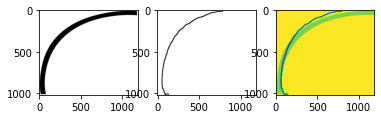

In [112]:
# img_test_path = r"C:\Users\idank\final_project\TestImages\11030\SimpleTestCrop\2.png"
# img_src_path = r"C:\Users\idank\final_project\OriginalImagesCrop\2.jpg"

# # img_path = r"C:\Users\idank\Desktop\profile.jfif"
# # img_path2 = r"C:\Users\idank\Desktop\profile_resized.jpg"
# src_img_obj_padd, best_ssim, best_padding, best_hand_copy_img_obj_resized_ratio_padd = new_ssim(src_img_path=img_src_path, hand_copy_img_path=img_test_path, width_jump=5, height_jump=2)

# img1 = np.array(src_img_obj_padd)
# img2 = np.array(best_hand_copy_img_obj_resized_ratio_padd)
# combine_img = img1 > img2

# print()
# print()
# print()
# print("best_ssim: " + str(best_ssim))
# print("best_padding: " + str(best_padding))
# f, axarr = plt.subplots(1,3)
# axarr[0].imshow(src_img_obj_padd, cmap='gray', vmin=0, vmax=255)
# axarr[1].imshow(best_hand_copy_img_obj_resized_ratio_padd, cmap='gray', vmin=0, vmax=255)
# axarr[2].imshow(cv2.addWeighted(src_img_obj_padd,0.2,best_hand_copy_img_obj_resized_ratio_padd,0.8,0))

# plt.show()

# Make lines Thin:

In [15]:
def getImageThinLines(image):
#     THINNING_GUOHALL / 
    ocv = cv2.ximgproc.thinning(image, None, cv2.ximgproc.THINNING_GUOHALL)
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(image, cmap='gray', vmin=127, vmax=255)
    axarr[1].imshow(ocv, cmap='gray', vmin=127, vmax=255)
    axarr[2].imshow(cv2.addWeighted(image,0.2,ocv,0.8,0))
    plt.show()
    return ocv

# img_src_path = r"C:\Users\idank\final_project\ShapeProject\OriginalImagesCrop\2.jpg"
# src_img_obj = cv2.imread(img_src_path, 0)
# getImageThinLines(src_img_obj)

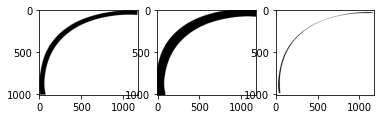

In [6]:
# import cv2  
# import numpy as np

# img_src_path = r"C:\Users\idank\final_project\ShapeProject\OriginalImagesCrop\2.jpg"

# img = cv2.imread(img_src_path, 0)
  
# kernel = np.ones((40,40), np.uint8)
# img_erosion = cv2.erode(img, kernel, iterations=1)
# img_dilation = cv2.dilate(img, kernel, iterations=1)
# f, axarr = plt.subplots(1,3)
# axarr[0].imshow(img, cmap='gray', vmin=0, vmax=255)
# axarr[1].imshow(img_erosion, cmap='gray', vmin=0, vmax=255)
# axarr[2].imshow(img_dilation, cmap='gray', vmin=0, vmax=255)
# # cv2.imshow('Input', img)  
# # cv2.imshow('Dilation', img_dilation)  
# # cv2.waitKey(0)  

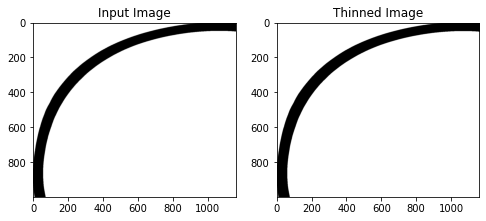

In [11]:
def getImageThinLines(image):
    # Threshold the image to create a binary image
    _, thresh = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

    # Define a structuring element
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))

    # Perform erosion
    eroded = cv2.erode(thresh, kernel, iterations=1)

    # Return the eroded image
    return eroded

# # Read the input image
# img_src_path = r"C:\Users\idank\final_project\ShapeProject\OriginalImagesCrop\2.jpg"
# img = cv2.imread(img_src_path, cv2.IMREAD_GRAYSCALE)

# # Get the thinned image
# thinned_img = getImageThinLines(img)

# # Plot the input and thinned images side by side
# fig, ax = plt.subplots(1, 2, figsize=(8, 4))
# ax[0].imshow(img, cmap="gray")
# ax[0].set_title("Input Image")
# ax[1].imshow(thinned_img, cmap="gray")
# ax[1].set_title("Thinned Image")
# plt.show()

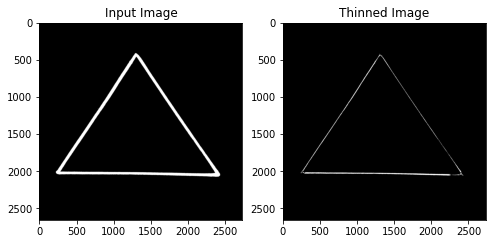

In [36]:
# import cv2
# import numpy as np

# # Create an image with text on it
# img_src_path = r"C:\Users\idank\final_project\ShapeProject\OriginalImagesCrop\Shap2.jpg"
# img = cv2.imread(img_src_path, cv2.IMREAD_GRAYSCALE)
# img1 = img.copy()

# # Structuring Element
# kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(21,21))
# # Create an empty output image to hold values
# thin = np.zeros(img.shape,dtype='uint8')

# # Loop until erosion leads to an empty set
# while (cv2.countNonZero(img1)!=0):
#     # Erosion
#     erode = cv2.erode(img1,kernel)
#     # Opening on eroded image
#     opening = cv2.morphologyEx(erode,cv2.MORPH_OPEN,kernel)
#     # Subtract these two
#     subset = erode - opening
#     # Union of all previous sets
#     thin = cv2.bitwise_or(subset,thin)
#     # Set the eroded image for next iteration
#     img1 = erode.copy()

# # Plot the input and thinned images side by side
# fig, ax = plt.subplots(1, 2, figsize=(8, 4))
# ax[0].imshow(img, cmap="gray")
# ax[0].set_title("Input Image")
# ax[1].imshow(thin, cmap="gray")
# ax[1].set_title("Thinned Image")
# plt.show()

# Sense Dataset:


DRAWING_1_CIRCLE.jpg:



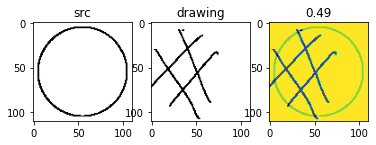

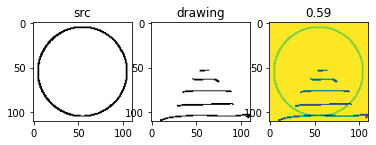

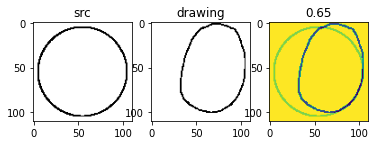

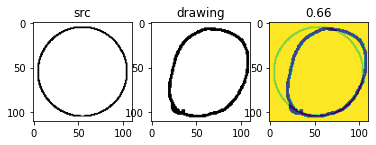

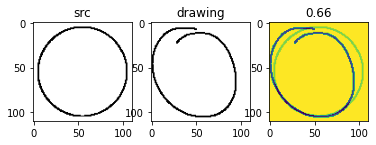

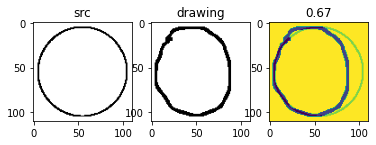

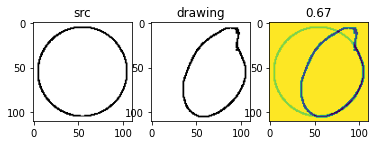

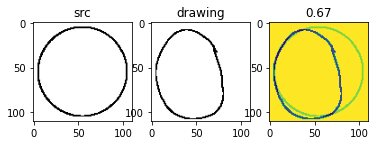

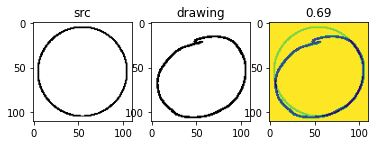

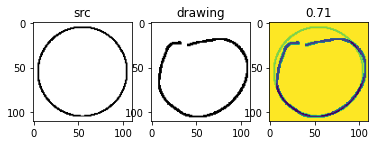

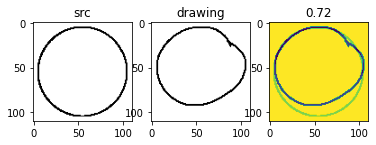

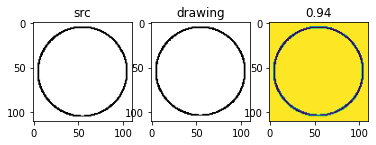


DRAWING_2_TRIANGLE.jpg:



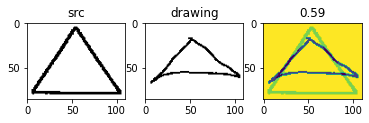

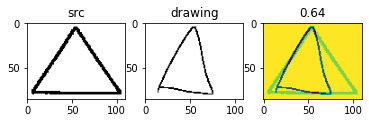

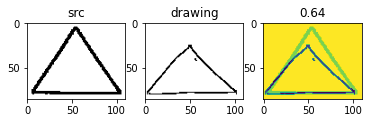

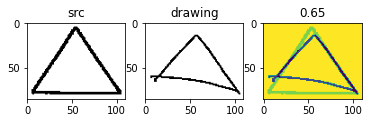

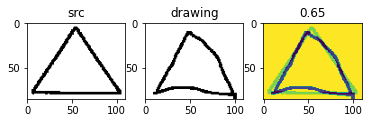

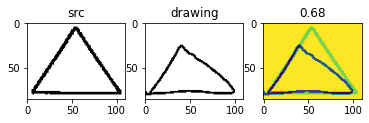

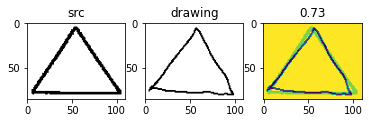

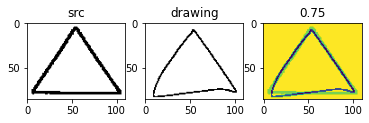

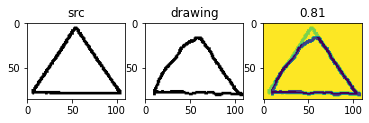


DRAWING_3.jpg:


DRAWING_4.jpg:


DRAWING_5.jpg:



In [25]:
folder_path = r'C:\Users\idank\final_project\ShapeProject\GetSenseDataset\src'
base_parent_path = r'C:\Users\idank\final_project\ShapeProject\GetSenseDataset\drawing'

for filename in os.listdir(folder_path):
    print(f'\n{filename}:\n')
    if filename.endswith('.jpg') or filename.endswith('.png'):
        src_path = os.path.join(folder_path, filename)
        img = cv2.imread(src_path)
        img_name = os.path.splitext(filename)[0]
        parent_folder_path = os.path.join(base_parent_path, img_name)
        if os.path.isdir(parent_folder_path):
            
            drawing_list = []
            ssim_score_list = []            
            for img_filename in os.listdir(parent_folder_path):
                if img_filename.endswith('.jpg') or img_filename.endswith('.png'):
                    hand_draw_path = os.path.join(parent_folder_path, img_filename)
                    src_img_obj_padd, best_ssim, best_padding, best_hand_copy_img_obj_resized_ratio_padd = new_ssim(src_img_path=src_path, hand_copy_img_path=hand_draw_path, width_jump=1, height_jump=1)
                    drawing_list.append(best_hand_copy_img_obj_resized_ratio_padd)
                    ssim_score_list.append(best_ssim)

            ssims_and_drawings = [[y,x] for y,x in sorted(zip(ssim_score_list, drawing_list))]
            for ssim_and_drawing in ssims_and_drawings:
                
                ssim_score = ssim_and_drawing[0]
                drawing = ssim_and_drawing[1]
                
                f, axarr = plt.subplots(1,3)
                axarr[0].imshow(src_img_obj_padd, cmap='gray', vmin=0, vmax=255)
                axarr[0].title.set_text('src')
                axarr[1].imshow(drawing, cmap='gray', vmin=0, vmax=255)
                axarr[1].title.set_text('drawing')
                axarr[2].imshow(cv2.addWeighted(src_img_obj_padd,0.2,drawing,0.8,0))
                axarr[2].title.set_text("{:.2f}".format(ssim_score))
                plt.show()
                
        else:
            print(f"Folder '{img_name}' not found!")

# another metrics:

In [ ]:
def hu_moments_similarity(contour1, contour2):
    hu1 = cv2.HuMoments(cv2.moments(contour1)).flatten()
    hu2 = cv2.HuMoments(cv2.moments(contour2)).flatten()
    hu1 = np.sign(hu1) * np.log10(np.abs(hu1))
    hu2 = np.sign(hu2) * np.log10(np.abs(hu2))
    similarity = 1 - np.linalg.norm(hu1 - hu2) / np.linalg.norm(hu1 + hu2)
    return similarity

def shape_context_similarity(contour1, contour2):
    sd = cv2.createShapeContextDistanceExtractor()
    similarity = 1 - sd.computeDistance(contour1, contour2)
    return similarity

def image_moments_similarity(contour1, contour2):
    moments1 = cv2.moments(contour1)
    moments2 = cv2.moments(contour2)
    similarity = 1 - np.linalg.norm(np.array(list(moments1.values())) - np.array(list(moments2.values()))) / np.linalg.norm(np.array(list(moments1.values())) + np.array(list(moments2.values())))
    return similarity

# def main():
#     image1 = cv2.imread("image1.png", cv2.IMREAD_GRAYSCALE)
#     image2 = cv2.imread("image2.png", cv2.IMREAD_GRAYSCALE)

#     contour1 = preprocess_image(image1)
#     contour2 = preprocess_image(image2)

#     hu_similarity = hu_moments_similarity(contour1, contour2)
#     print(f"Hu Moments Similarity: {hu_similarity}")

#     shape_context_similarity_score = shape_context_similarity(contour1, contour2)
#     print(f"Shape Context Similarity: {shape_context_similarity_score}")

#     image_moments_similarity_score = image_moments_similarity(contour1, contour2)
#     print(f"Image Moments Similarity: {image_moments_similarity_score}")

# if __name__ == "__main__":
#     main()